In [1]:
import pandas as pd
import numpy as np

from data_loader import data_load_and_split

big_firstMeas_train, big_secondMeas_train, big_firstMeas_test, big_secondMeas_test, trimmed_firstMeas_train, trimmed_secondMeas_train, trimmed_firstMeas_test, trimmed_secondMeas_test = data_load_and_split()


/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/data_loader.py:5: DtypeWarning: Columns (86,168,207,211,215) have mixed types. Specify dtype option on import or set low_memory=False.
  def data_load_and_split(big_data=pd.read_csv('../Data/final_big_data.csv'),
/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/data_loader.py:6: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trimmed_data= pd.read_csv('../Data/trimmed_data.csv'),


In [2]:
from data_loader import data_merge

combined_train =data_merge(trimmed_firstMeas_train, trimmed_secondMeas_train)

SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.


## On to the data science!

In [4]:
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7443 entries, 0 to 9724
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  7443 non-null   int64  
 1   ALIVE_pre_burn      7443 non-null   int64  
 2   CULL_pre_burn       6751 non-null   float64
 3   DIA_pre_burn        7443 non-null   float64
 4   HT_pre_burn         7443 non-null   float64
 5   DRYBIO_AG_pre_burn  7443 non-null   float64
 6   ELEV                7443 non-null   float64
 7   SOFTWOOD            7443 non-null   int64  
 8   YRS_SINCE_BURN      7443 non-null   float64
 9   NUM_BURNS           7443 non-null   int64  
 10  BURN_AREA_TOTAL     7443 non-null   float64
 11  ALIVE_post_burn     7443 non-null   int64  
 12  CULL_post_burn      5764 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 814.1 KB


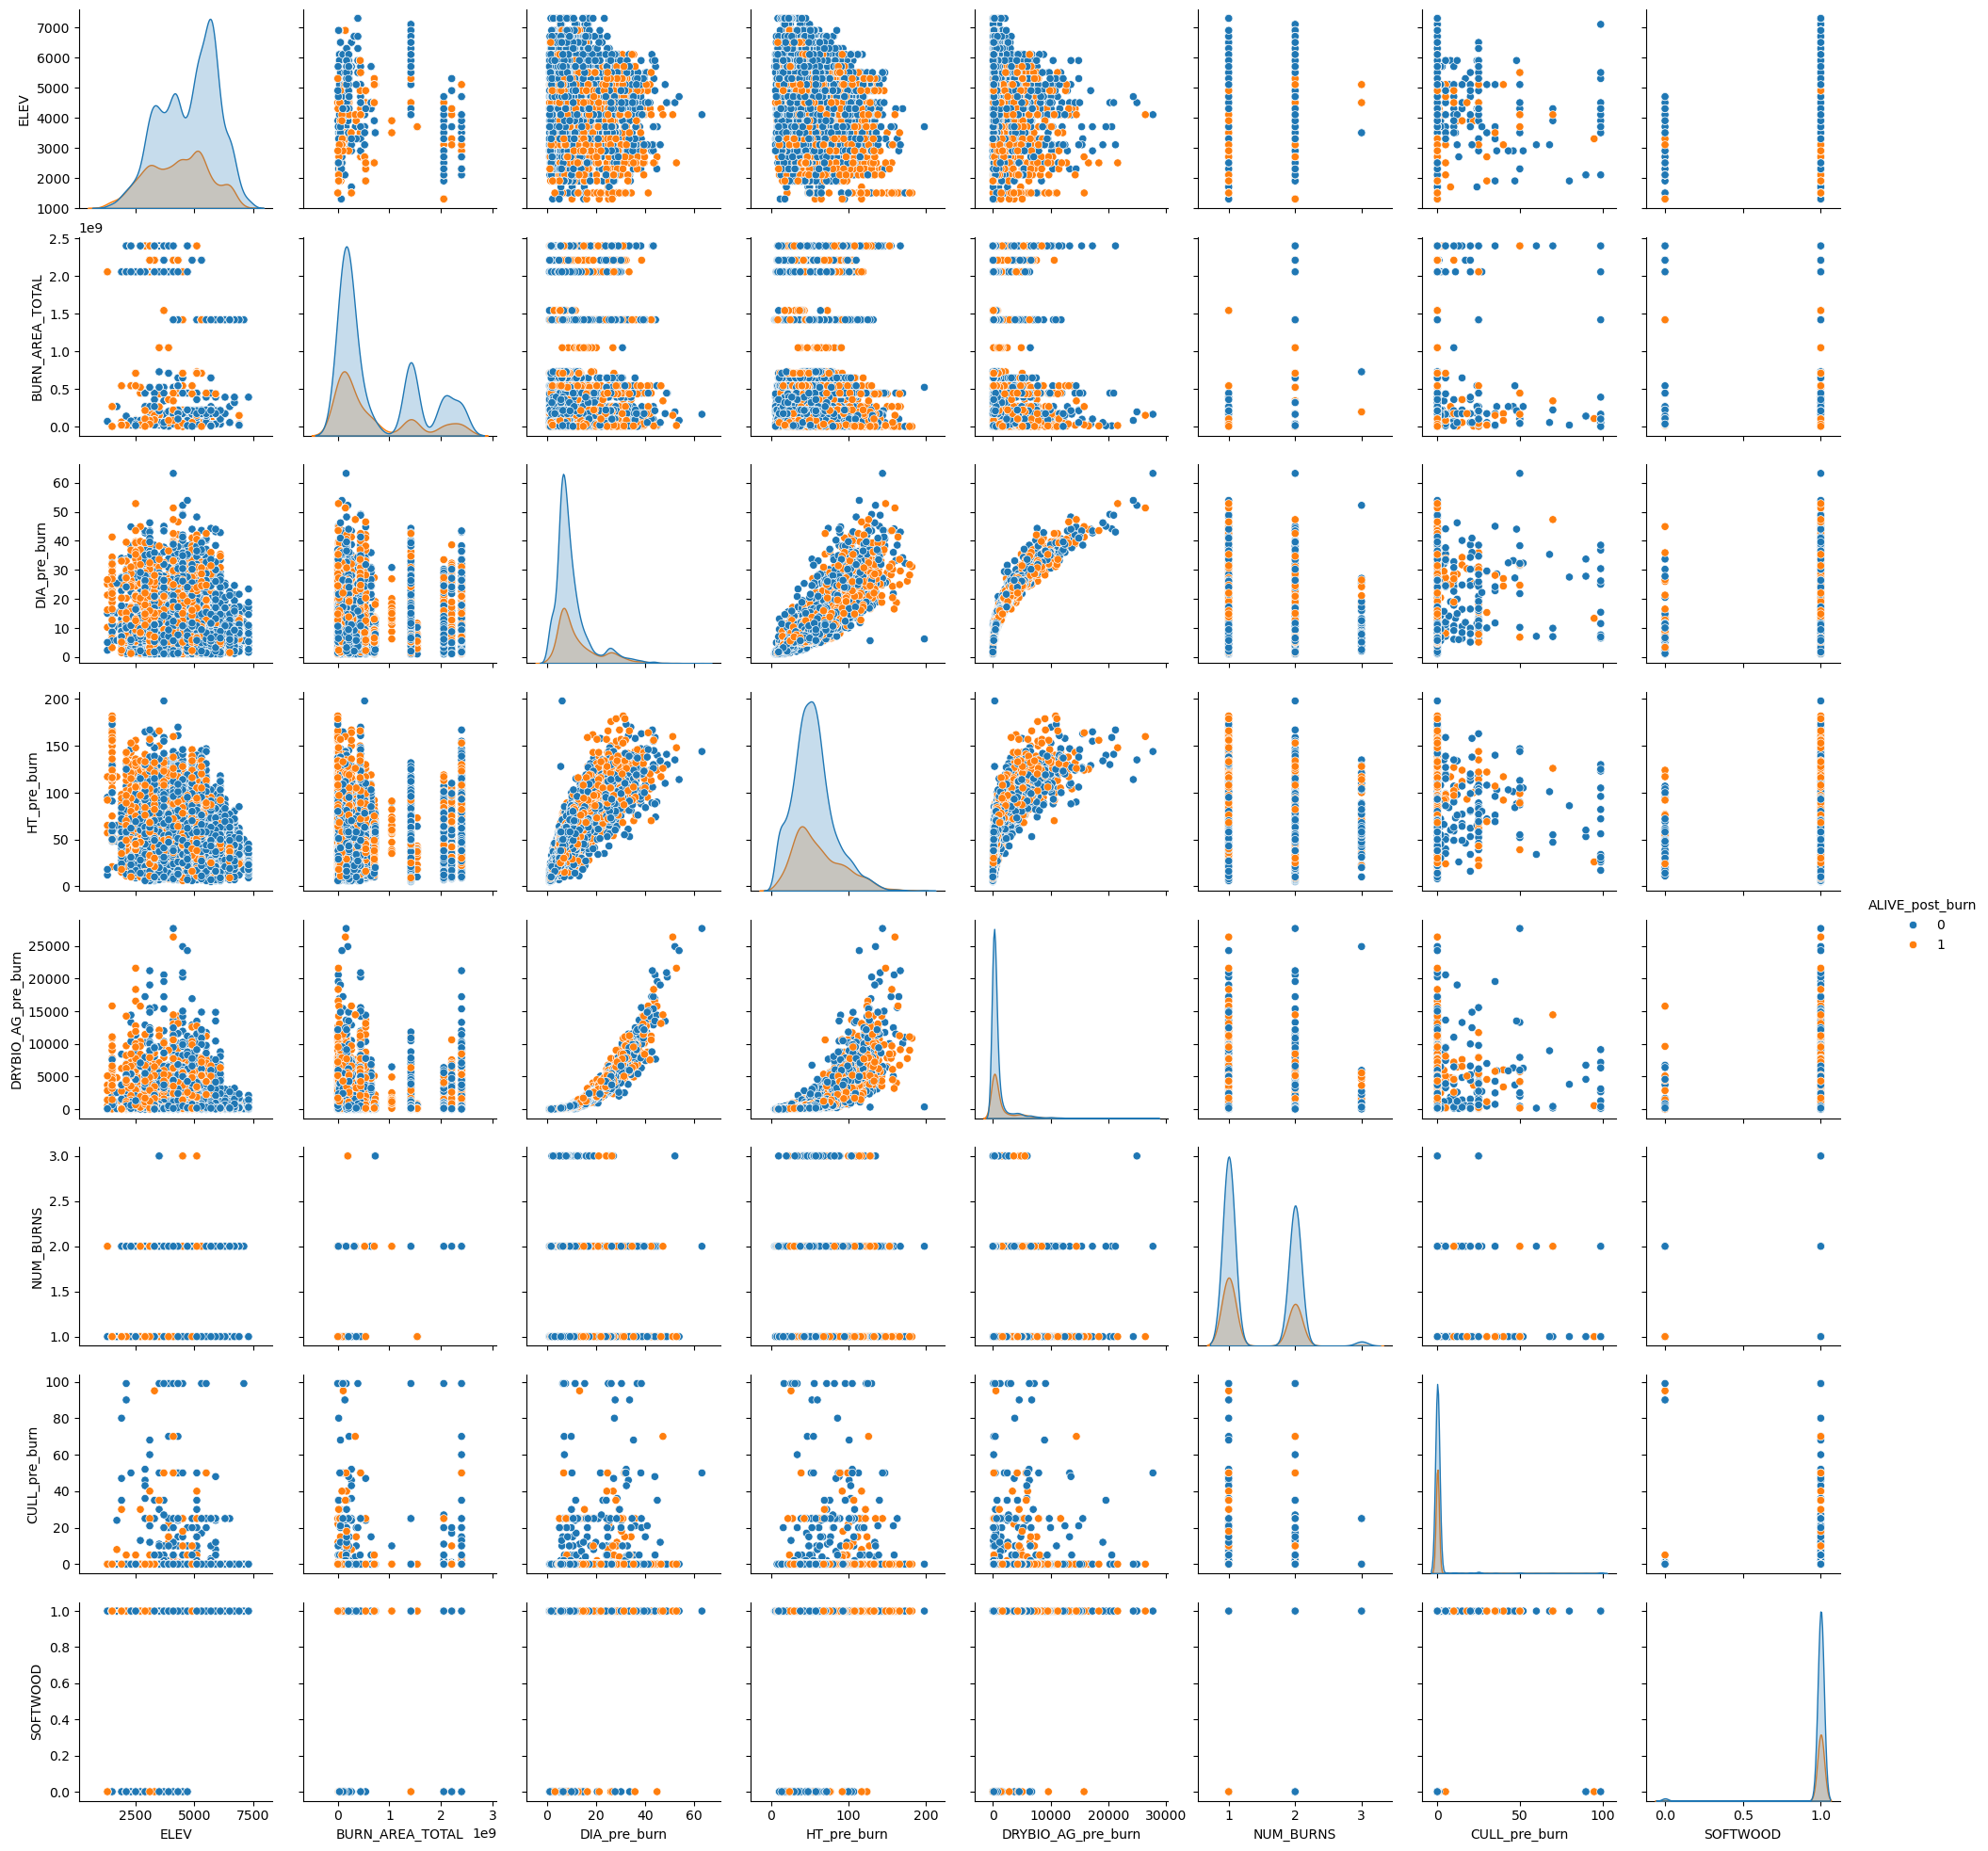

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.pairplot(combined_train[["ELEV", "BURN_AREA_TOTAL","DIA_pre_burn","HT_pre_burn","DRYBIO_AG_pre_burn","NUM_BURNS","CULL_pre_burn","ALIVE_post_burn","SOFTWOOD"]],hue="ALIVE_post_burn")

Based on these plots, we could maybe do some classification methods using diameter, height, cull damage, number of fires, and area of burn However, diameter, height, and dry bio age look to be highly correlated, so let's only use one. Also, it looks like a linear decision line could be drawn between height/diameter and elevation nicely. 

In [3]:
# Let's not do Cull for now as there are some nan values
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL"]

**SVC**

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import scipy.stats


In [6]:
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=218, 
                        shuffle=True)

dummy_clf_mostfrequent = DummyClassifier(strategy='most_frequent', random_state=218)
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=218)
DummyAccuracies = np.zeros((n_splits, 2))


for i,(train_index, test_index) in enumerate(kfold.split(combined_train[indicator_features],combined_train['ALIVE_post_burn'])):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
        
        
    dummy_clf_stratified.fit(trees_tt[indicator_features],trees_tt[['ALIVE_post_burn']])
    dummy_pred_stratified = dummy_clf_stratified.predict(trees_ho[indicator_features])
    dummy_clf_mostfrequent.fit(trees_tt[indicator_features],trees_tt[['ALIVE_post_burn']])
    dummy_pred_mostfrequent = dummy_clf_mostfrequent.predict(trees_ho[indicator_features])
    
    DummyAccuracies[i,0] = accuracy_score(trees_ho['ALIVE_post_burn'], dummy_pred_stratified)
    DummyAccuracies[i,1] = accuracy_score(trees_ho['ALIVE_post_burn'], dummy_pred_mostfrequent)



In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('svc', SVC())  # Classifier step
])
param_grid = {
    'svc__C': [0.1,1,10,50],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#    'svc__degree': [2, 3],  # Applies only to 'poly'
#    'svc__gamma': ['scale', 'auto']  # Applies to 'rbf' and 'sigmoid'
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,  
    verbose=2, 
)
grid_search.fit(combined_train[indicator_features], combined_train['ALIVE_post_burn'].values)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.4s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.7s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.8s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.7s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.9s
[CV] END ........................svc__C=0.1, svc__kernel=rbf; total time=   1.5s
[CV] END ........................svc__C=0.1, svc

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=218, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 50],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [10]:
# Find optimal parameters 
cv_results = pd.DataFrame(grid_search.cv_results_)
best_kernel = grid_search.best_params_['svc__kernel']
best_index = grid_search.best_index_  # Index of the best parameter set
print(cv_results.iloc[best_index])   # Full details of the best set


mean_fit_time                                    1.111324
std_fit_time                                      0.05684
mean_score_time                                   0.38827
std_score_time                                   0.003586
param_svc__C                                         50.0
param_svc__kernel                                     rbf
params               {'svc__C': 50, 'svc__kernel': 'rbf'}
split0_test_score                                0.767629
split1_test_score                                0.764271
split2_test_score                                0.752183
split3_test_score                                    0.75
split4_test_score                                0.751344
mean_test_score                                  0.757085
std_test_score                                   0.007349
rank_test_score                                         1
Name: 14, dtype: object


In [26]:
print(f"Accuracy of Dummy Classifier with Stratified Strategy: {np.mean(DummyAccuracies[:,0],):.2f}")
print(f"Accuracy of Dummy Classifier with Most Frequent Strategy: {np.mean(DummyAccuracies[:,1],):.2f}")

Accuracy of Dummy Classifier with Stratified Strategy: 0.61
Accuracy of Dummy Classifier with Most Frequent Strategy: 0.72


The SVC with the RBF kernel did the best. Also it outdid the baseline (75.2% compared to 61% (stratified) or 72% (most frequent). Let's try to tune this more.

In [7]:
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=218, 
                        shuffle=True)

Cvalues = [.001,.01,1,50,70,80,100,150,1e3]
C_accuracies_rbf = np.zeros((n_splits, len(Cvalues)))




for i,(train_index, test_index) in enumerate(kfold.split(combined_train[indicator_features],combined_train['ALIVE_post_burn'])):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
    for j,C in enumerate(Cvalues):
        pipe_rbf = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=C))])

        
        pipe_rbf.fit(trees_tt[indicator_features],
                    trees_tt['ALIVE_post_burn'])

        
        pred_rbf = pipe_rbf.predict(trees_ho[indicator_features])


        C_accuracies_rbf[i, j] = accuracy_score(trees_ho['ALIVE_post_burn'], pred_rbf)


In [16]:
mean_cv_accuracy = np.mean(C_accuracies_rbf, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_C = Cvalues[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

mean_df = pd.DataFrame({
    "C": Cvalues,
    "Mean": mean_cv_accuracy
})

print(mean_df)
print(f"The optimal C was {optimal_C} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

          C      Mean
0     0.001  0.722424
1     0.010  0.722424
2     1.000  0.731424
3    50.000  0.757085
4    70.000  0.757623
5    80.000  0.757489
6   100.000  0.756817
7   150.000  0.756951
8  1000.000  0.758698
The optimal C was 1000.0 which gave a mean CV accuracy of 0.759


Seems that C= 1000 gives the best accuracy score. However, this could lead to overfitting. So, maybe we stick with C=50 and then try to tune more.

Let's try to see how the model does if we have different combos of the features

In [15]:
import itertools

# Example array

# Get all combinations with length 1 to the total number of components
all_combinations = []
for r in range(1, len(indicator_features) + 1):
    all_combinations.extend(itertools.combinations(indicator_features, r))

# Convert combinations to a list of lists for readability
all_combinations = [list(comb) for comb in all_combinations]
print(all_combinations)


[['ELEV'], ['HT_pre_burn'], ['BURN_AREA_TOTAL'], ['ELEV', 'HT_pre_burn'], ['ELEV', 'BURN_AREA_TOTAL'], ['HT_pre_burn', 'BURN_AREA_TOTAL'], ['ELEV', 'HT_pre_burn', 'BURN_AREA_TOTAL']]


In [18]:
Feature_Accuracies = np.zeros((n_splits,len(all_combinations)))
for i,(train_index, test_index) in enumerate(kfold.split(combined_train[indicator_features],combined_train['ALIVE_post_burn'])):
    trees_tt = combined_train.iloc[train_index]
    trees_ho = combined_train.iloc[test_index]
    for j,features in enumerate(all_combinations):
        pipe_rbf = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=70))])
        
        pipe_rbf.fit(trees_tt[features],
                    trees_tt['ALIVE_post_burn'])

        
        pred_rbf = pipe_rbf.predict(trees_ho[features])


        Feature_Accuracies[i, j] = accuracy_score(trees_ho['ALIVE_post_burn'], pred_rbf)

In [24]:
mean_cv_accuracy = np.mean(Feature_Accuracies, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_features = all_combinations[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

mean_df = pd.DataFrame({
    "Features Used": all_combinations,
    "Mean": mean_cv_accuracy
})

print(mean_df)
print(f"The optimal combination of features was {optimal_features} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

                          Features Used      Mean
0                                [ELEV]  0.724170
1                         [HT_pre_burn]  0.721886
2                     [BURN_AREA_TOTAL]  0.723366
3                   [ELEV, HT_pre_burn]  0.732768
4               [ELEV, BURN_AREA_TOTAL]  0.743921
5        [HT_pre_burn, BURN_AREA_TOTAL]  0.735858
6  [ELEV, HT_pre_burn, BURN_AREA_TOTAL]  0.757623
The optimal combination of features was ['ELEV', 'HT_pre_burn', 'BURN_AREA_TOTAL'] which gave a mean CV accuracy of 0.758


Okay so the best combination of features is in fact when all three are used. However, we get good accuracy of 72% when single features are used too. This is most likely due to the class proportions being very imbalanced anyways. Let's see what happens if we use Cull too. We need to first get rid of the nan values for this. 

In [28]:
combined_train_trimmed = combined_train.dropna(subset=["CULL_pre_burn"])
combined_train_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6751 entries, 0 to 9724
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CN                  6751 non-null   int64  
 1   ALIVE_pre_burn      6751 non-null   int64  
 2   CULL_pre_burn       6751 non-null   float64
 3   DIA_pre_burn        6751 non-null   float64
 4   HT_pre_burn         6751 non-null   float64
 5   DRYBIO_AG_pre_burn  6751 non-null   float64
 6   ELEV                6751 non-null   float64
 7   SOFTWOOD            6751 non-null   int64  
 8   YRS_SINCE_BURN      6751 non-null   float64
 9   NUM_BURNS           6751 non-null   int64  
 10  BURN_AREA_TOTAL     6751 non-null   float64
 11  ALIVE_post_burn     6751 non-null   int64  
 12  CULL_post_burn      5739 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 738.4 KB


In [32]:
Accuracies_includingCull = np.zeros((n_splits,1))
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL","CULL_pre_burn"]
for i,(train_index, test_index) in enumerate(kfold.split(combined_train_trimmed[indicator_features],combined_train_trimmed['ALIVE_post_burn'])):
    trees_tt = combined_train_trimmed.iloc[train_index]
    trees_ho = combined_train_trimmed.iloc[test_index]
    pipe_rbf = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=70))])

        
    pipe_rbf.fit(trees_tt[indicator_features],
                    trees_tt['ALIVE_post_burn'])

        
    pred_rbf = pipe_rbf.predict(trees_ho[indicator_features])


    Accuracies_includingCull[i] = accuracy_score(trees_ho['ALIVE_post_burn'], pred_rbf)
print(f"The mean CV accuracy including Cull is {np.mean(Accuracies_includingCull):.3f}")

The mean CV accuracy including Cull is 0.740


Okay, so including Cull made the mean CV accuracy worse.

Let's try tuning gamma in the RBF kernel to improve accuracy

In [13]:
indicator_features = ["ELEV","HT_pre_burn","BURN_AREA_TOTAL"]

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('svc', SVC(C=50))  # Classifier step
])
param_grid = {
#    'svc__degree': [2, 3],  # Applies only to 'poly'
    'svc__gamma': np.logspace(-9, 3, 13)  
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,  
    verbose=2, 
)
grid_search.fit(combined_train[indicator_features], combined_train['ALIVE_post_burn'].values)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END ...................................svc__gamma=1e-09; total time=   0.9s
[CV] END ...................................svc__gamma=1e-09; total time=   0.9s
[CV] END ...................................svc__gamma=1e-09; total time=   0.9s
[CV] END ...................................svc__gamma=1e-09; total time=   0.9s
[CV] END ...................................svc__gamma=1e-09; total time=   0.9s
[CV] END ...................................svc__gamma=1e-08; total time=   0.9s
[CV] END ...................................svc__gamma=1e-08; total time=   0.9s
[CV] END ...................................svc__gamma=1e-08; total time=   0.8s
[CV] END ...................................svc__gamma=1e-08; total time=   0.8s
[CV] END ...................................svc__gamma=1e-08; total time=   0.9s
[CV] END ...................................svc__gamma=1e-07; total time=   0.8s
[CV] END ...................................svc_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=218, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(C=50))]),
             param_grid={'svc__gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='accuracy', verbose=2)

In [15]:
# Find optimal Gamma
cv_results = pd.DataFrame(grid_search.cv_results_)
best_kernel = grid_search.best_params_
best_index = grid_search.best_index_  # Index of the best parameter set
print(cv_results.iloc[best_index])   # Full details of the best set
print(cv_results)

mean_fit_time                    1.712189
std_fit_time                     0.057118
mean_score_time                  0.317539
std_score_time                   0.003508
param_svc__gamma                     10.0
params               {'svc__gamma': 10.0}
split0_test_score                0.779718
split1_test_score                0.789792
split2_test_score                0.775017
split3_test_score                 0.77621
split4_test_score                0.786962
mean_test_score                   0.78154
std_test_score                   0.005861
rank_test_score                         1
Name: 10, dtype: object
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.481130      0.028331         0.393240        0.001325   
1        0.468260      0.011343         0.393762        0.003917   
2        0.462708      0.004482         0.390541        0.001348   
3        0.466327      0.013232         0.391814        0.004925   
4        0.462385      0.007802         0.396325

Gamma value of 10 increases accuracy to 78%! However this is a very high gamma value and is likely overfitting the data